In [1]:
import os
import numpy as np
import torch
import importlib
import consts
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from scipy.spatial.distance import cdist
from scipy.stats import ortho_group
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import pandas as pd
import random
from toolbox.alias_multinomial import AliasMultinomial

# 重新載入 consts 以確保變數最新
importlib.reload(consts)
torch.manual_seed(consts.SEED)
np.random.seed(consts.SEED)

In [2]:
# 確保輸出目錄存在
output_dir = "newsgroup_test"
os.makedirs(output_dir, exist_ok=True)

#下載 20 Newsgroups 資料集並轉換為 BoW
categories = None #下載所有分類的資料
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes')) #移除標題、頁尾及引用，減少雜訊
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
raw_texts = newsgroups_train.data  # ✅ 這是原始文本

vectorizer = CountVectorizer(max_features=5000, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]{3,}\b')#設定文本轉換為bag-of-words，只保留5000個最常出現的單字，移除常見英文停用詞，只允許至少 3 個英文字母的單詞
X_train = vectorizer.fit_transform(newsgroups_train.data).toarray() #將newgroups的資料建立詞彙表(bow)w
X_test = vectorizer.transform(newsgroups_test.data).toarray() #同樣的詞彙表，套用給valid data
#vocab = vectorizer.get_feature_names_out() #所有被納入詞袋單字的單字表
y_train = np.array(newsgroups_train.target) #代表這篇文章屬於哪個分類
y_test = np.array(newsgroups_test.target)

In [3]:
from nltk.tokenize import word_tokenize

# ✅ 修正：確保 raw_texts 為 list，過濾 None 和空字串
tokenized_texts = [word_tokenize(str(doc).lower()) for doc in raw_texts if isinstance(doc, str) and doc.strip()]

# ✅ 檢查 Tokenization 是否成功
print(f"Total Documents: {len(tokenized_texts)}")
print(f"Example Tokenized Texts: {tokenized_texts[:3]}")  # 顯示前 3 個 Tokenized 結果

Total Documents: 11014
Example Tokenized Texts: [['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', '.', 'it', 'was', 'a', '2-door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s', '.', 'it', 'was', 'called', 'a', 'bricklin', '.', 'the', 'doors', 'were', 'really', 'small', '.', 'in', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'this', 'is', 'all', 'i', 'know', '.', 'if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs', ',', 'years', 'of', 'production', ',', 'where', 'this', 'car', 'is', 'made', ',', 'history', ',', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', ',', 'please', 'e-mail', '.'], ['a', 'fair', 'number', 'of', 'brave', 'souls', 'who', 'upgraded', 'their', 'si', 'clock', 'oscillator', 'have', 'shared', 'their', 'experien

In [97]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# ✅ 確保 NLTK 停用詞 (stopwords) 可用
nltk.download("stopwords")

# 停用詞列表 (例如 "the", "to", "and" 這些常見詞)
stop_words = set(stopwords.words("english"))

# 設定最大詞彙數量
MAX_VOCAB_SIZE = 5000

# **過濾標點符號、數字、停用詞**
cleaned_texts = []
for doc in tokenized_texts:
    cleaned_doc = [word.lower() for word in doc if word.isalpha() and word.lower() not in stop_words]
    cleaned_texts.append(cleaned_doc)

# 計算詞頻
word_counts = Counter(word for doc in cleaned_texts for word in doc)

# **只保留前 5000 個最常見的詞**
most_common_words = word_counts.most_common(MAX_VOCAB_SIZE)

# **建立詞彙表**
vocab = {word: idx for idx, (word, _) in enumerate(most_common_words)}

# ✅ 打印 vocab 內部示例
print("詞彙表大小:", len(vocab))  # 應該 <= 5000
print("前 10 個詞:", list(vocab.items())[:50])  # 顯示前 10 個詞

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HungLin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


詞彙表大小: 5000
前 10 個詞: [('would', 0), ('one', 1), ('x', 2), ('max', 3), ('people', 4), ('like', 5), ('get', 6), ('know', 7), ('also', 8), ('q', 9), ('use', 10), ('think', 11), ('could', 12), ('time', 13), ('g', 14), ('r', 15), ('new', 16), ('good', 17), ('may', 18), ('well', 19), ('even', 20), ('first', 21), ('see', 22), ('p', 23), ('two', 24), ('much', 25), ('many', 26), ('us', 27), ('make', 28), ('way', 29), ('system', 30), ('god', 31), ('used', 32), ('n', 33), ('say', 34), ('right', 35), ('said', 36), ('want', 37), ('file', 38), ('anyone', 39), ('need', 40), ('work', 41), ('something', 42), ('problem', 43), ('since', 44), ('please', 45), ('w', 46), ('go', 47), ('c', 48), ('information', 49)]


In [84]:
# 印出 vectorizer 設定及詞彙部分樣本
print("Vectorizer 設定:")
print(vectorizer)
print("\n詞彙樣本 (前 20 個單詞):")
print(vocab[:20])

# 印出 BoW 資料形狀與標籤
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train 樣本 (前 10 筆):", y_train[:10])
print("y_test 樣本 (前 10 筆):", y_test[:10])

# 使用 DataFrame 顯示訓練資料的前 5 筆（每筆資料包含詞彙計數）
df_train = pd.DataFrame(X_train[:5], columns=vocab)
# 加入分類名稱（根據 target 索引轉換為類別名稱）
df_train.insert(0, "Category", [newsgroups_train.target_names[i] for i in y_train[:5]])
print("\n訓練資料樣本 (前 5 筆):")
print(df_train.head())

# 印出前 3 筆原始文本內容（顯示前 500 個字元）
print("\n原始文本樣本 (前 3 筆):")
for i in range(3):
    print(f"\n文件 {i+1} (分類: {newsgroups_train.target_names[y_train[i]]}):")
    print(newsgroups_train.data[i][:500])

Vectorizer 設定:
CountVectorizer(max_features=5000, stop_words='english',
                token_pattern='(?u)\\b[A-Za-z]{3,}\\b')

詞彙樣本 (前 20 個單詞):
['aaa' 'abc' 'abiding' 'ability' 'able' 'abort' 'abortion' 'abs' 'absence'
 'absolute' 'absolutely' 'abstract' 'abuse' 'abuses' 'academic'
 'acceleration' 'accelerator' 'accept' 'acceptable' 'acceptance']

X_train shape: (11314, 5000)
X_test shape: (7532, 5000)

y_train 樣本 (前 10 筆): [ 7  4  4  1 14 16 13  3  2  4]
y_test 樣本 (前 10 筆): [ 7  5  0 17 19 13 15 15  5  1]

訓練資料樣本 (前 5 筆):
                Category  aaa  abc  abiding  ability  able  abort  abortion  \
0              rec.autos    0    0        0        0     0      0         0   
1  comp.sys.mac.hardware    0    0        0        0     0      0         0   
2  comp.sys.mac.hardware    0    0        0        0     0      0         0   
3          comp.graphics    0    0        0        0     0      0         0   
4              sci.space    0    0        0        0     0      0         

In [ ]:
#產生 word_counts 與 doc_lens
#word_counts = np.sum(X_train, axis=0)
doc_lens_train = np.sum(X_train, axis=1)
doc_lens_test = np.sum(X_test, axis=1)

In [93]:
#轉換為 PyTorch Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [98]:
#產生 doc_windows（上下文窗口）
def get_windows(bow_matrix, window_size=5):
    n_docs, vocab_size = bow_matrix.shape
    windows = []
    for doc_idx in range(n_docs):
        indices = np.nonzero(bow_matrix[doc_idx])[0]
        if len(indices) >= window_size:
            for i in range(len(indices) - window_size + 1):
                window = indices[i:i+window_size]
                windows.append([doc_idx] + list(window))
    return np.array(windows)

doc_windows = get_windows(X_train)

In [99]:
def get_windows_revise(tokenized_texts, vocab, window_size=5):
    """
    根據原始文本的詞序生成對稱的上下文窗口，讓 pivot_word 在正中央。
    
    Parameters:
    - tokenized_texts (List[List[str]]): 已分詞的文本列表，每個文本是一個詞的列表。
    - vocab (Dict[str, int]): 詞彙表，映射詞到索引，例如 {"apple": 0, "banana": 1, ...}
    - window_size (int): 窗口大小（應該是奇數，以確保 pivot_word 在正中央）。
    
    Returns:
    - np.array: 每行為 [doc_idx, pivot_word, context_word1, context_word2, ...]
    """
    windows = []
    half_window = window_size // 2  # 左右各取 `half_window` 個詞

    for doc_idx, tokens in enumerate(tokenized_texts):
        indexed_tokens = [vocab[word] for word in tokens if word in vocab]  # 將文本轉換為索引
        
        if len(indexed_tokens) >= 2:  # 確保至少有兩個詞
            for i in range(len(indexed_tokens)):
                pivot = indexed_tokens[i]  # 中心詞
                
                # 計算前後詞的範圍，確保不超出文本範圍
                start_idx = max(0, i - half_window)  # 確保索引不低於 0
                end_idx = min(len(indexed_tokens), i + half_window + 1)  # 確保索引不超過最大範圍
                
                context = indexed_tokens[start_idx:i] + indexed_tokens[i + 1:end_idx]  # 前後取詞
                windows.append([doc_idx, pivot] + context)  # 輸出格式：[doc_idx, pivot_word, context_word1, ...]

    return np.array(windows, dtype=object)  # 使用 dtype=object 以防長度不一致

In [100]:
# 生成前後對稱的上下文窗口
doc_windows = get_windows_revise(tokenized_texts, vocab, window_size=5)

# 查看窗口數據
print(doc_windows[:5])  # 只顯示前 5 個窗口

[list([0, 1060, 39, 12]) list([0, 39, 1060, 12, 157])
 list([0, 12, 1060, 39, 157, 377]) list([0, 157, 39, 12, 377, 139])
 list([0, 377, 12, 157, 139, 2127])]


In [101]:
# 建立 vocab 的反向字典
index_to_word = {idx: word for word, idx in vocab.items()}

# 轉換數字回詞
def decode_window(window):
    doc_idx = window[0]
    pivot_word = index_to_word[window[1]] if window[1] in index_to_word else "<UNK>"
    context_words = [index_to_word[idx] if idx in index_to_word else "<UNK>" for idx in window[2:]]
    return [doc_idx, pivot_word] + context_words

# 測試解碼
decoded_windows = [decode_window(window) for window in doc_windows[:5]]
for w in decoded_windows:
    print(w)

[0, 'wondering', 'anyone', 'could']
[0, 'anyone', 'wondering', 'could', 'car']
[0, 'could', 'wondering', 'anyone', 'car', 'saw']
[0, 'car', 'anyone', 'could', 'saw', 'day']
[0, 'saw', 'could', 'car', 'day', 'sports']


In [102]:
raw_texts[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [90]:
from collections import Counter

# 建立詞頻計算
word_counts = Counter(word for doc in raw_texts for word in doc)

# ✅ 構建詞彙表字典 {word: index}
vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}

print(type(vocab))  # 應該是 <class 'dict'>

<class 'dict'>


In [91]:
import torch

def get_windows_gpu(tokenized_texts, vocab, window_size=5, device="cuda"):
    """
    在 GPU 上生成前後對稱的上下文窗口。
    """
    windows = []
    half_window = window_size // 2  

    # ✅ 修正：確保 `vocab` 是 dict
    assert isinstance(vocab, dict), "Error: vocab 必須是字典類型 {word: index}"

    # 轉換 vocab 為 PyTorch Tensor
    vocab_tensor = {word: torch.tensor(idx, device=device) for word, idx in vocab.items()}

    for doc_idx, tokens in enumerate(tokenized_texts):
        indexed_tokens = torch.tensor(
            [vocab_tensor[word] for word in tokens if word in vocab_tensor], device=device
        )

        if indexed_tokens.shape[0] >= 2:  
            for i in range(indexed_tokens.shape[0]):
                pivot = indexed_tokens[i]  

                start_idx = max(0, i - half_window)  
                end_idx = min(indexed_tokens.shape[0], i + half_window + 1)  

                context = torch.cat((indexed_tokens[start_idx:i], indexed_tokens[i + 1:end_idx]))  

                windows.append(torch.cat((torch.tensor([doc_idx], device=device), pivot.unsqueeze(0), context)))

    return torch.stack(windows)  # 回傳 GPU Tensor

# ✅ 生成上下文窗口
doc_windows_gpu = get_windows_gpu(tokenized_texts, vocab, window_size=5)

# 查看前 5 個窗口
print(doc_windows_gpu[:5])

RuntimeError: stack expects each tensor to be equal size, but got [4] at entry 0 and [5] at entry 1

In [10]:
print("前 20 個詞:", doc_windows_revise[:20])  # 確認前 20 個詞是否合理

前 20 個詞: [list([0, 58, 495, 610]) list([0, 495, 58, 610, 642])
 list([0, 610, 58, 495, 642, 1128]) list([0, 642, 495, 610, 1128, 1356])
 list([0, 1128, 610, 642, 1356, 1357])
 list([0, 1356, 642, 1128, 1357, 1400])
 list([0, 1357, 1128, 1356, 1400, 1474])
 list([0, 1400, 1356, 1357, 1474, 2067])
 list([0, 1474, 1357, 1400, 2067, 2226])
 list([0, 2067, 1400, 1474, 2226, 2444])
 list([0, 2226, 1474, 2067, 2444, 2476])
 list([0, 2444, 2067, 2226, 2476, 2613])
 list([0, 2476, 2226, 2444, 2613, 2614])
 list([0, 2613, 2444, 2476, 2614, 2655])
 list([0, 2614, 2476, 2613, 2655, 2846])
 list([0, 2655, 2613, 2614, 2846, 3470])
 list([0, 2846, 2614, 2655, 3470, 3636])
 list([0, 3470, 2655, 2846, 3636, 3787])
 list([0, 3636, 2846, 3470, 3787, 3923])
 list([0, 3787, 3470, 3636, 3923, 4019])]


In [8]:
print("前 20 個詞:", doc_windows[:20])  # 確認前 20 個詞是否合理

前 20 個詞: [[   0   58  495  610  642 1128]
 [   0  495  610  642 1128 1356]
 [   0  610  642 1128 1356 1357]
 [   0  642 1128 1356 1357 1400]
 [   0 1128 1356 1357 1400 1474]
 [   0 1356 1357 1400 1474 2067]
 [   0 1357 1400 1474 2067 2226]
 [   0 1400 1474 2067 2226 2444]
 [   0 1474 2067 2226 2444 2476]
 [   0 2067 2226 2444 2476 2613]
 [   0 2226 2444 2476 2613 2614]
 [   0 2444 2476 2613 2614 2655]
 [   0 2476 2613 2614 2655 2846]
 [   0 2613 2614 2655 2846 3470]
 [   0 2614 2655 2846 3470 3636]
 [   0 2655 2846 3470 3636 3787]
 [   0 2846 3470 3636 3787 3923]
 [   0 3470 3636 3787 3923 4019]
 [   0 3636 3787 3923 4019 4154]
 [   0 3787 3923 4019 4154 4221]]


In [103]:
def set_seed(seed=9527):
    """
    設置隨機種子，確保結果可重現。
    
    Parameters:
    - seed (int): 隨機種子數值
    """
    random.seed(seed)  # 設置 Python 內建 random 庫的種子
    np.random.seed(seed)  # 設置 NumPy 的隨機種子
    torch.manual_seed(seed)  # 設置 PyTorch 的隨機種子
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設置 GPU 隨機種子
        torch.cuda.manual_seed_all(seed)  # 設置所有 GPU 的隨機種子
        torch.backends.cudnn.deterministic = True  # 確保 cuDNN 生成的結果可重現
        torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 自適應優化，確保可重現性

In [104]:
#自訂 PyTorch Dataset，將已產生的上下文資料，包裝成pytorch可使用的資料集物件
class DocWindowsDataset(Dataset):
    def __init__(self, windows):
        self.data = windows

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

In [105]:
#概念挖掘模型
class GuidedDiverseConceptMiner(nn.Module):
    def __init__(self, vocab, vocab_size, nconcepts=10, embed_dim=50, nnegs=15, bow_train=None, y_train=None, doc_windows=None, word_counts=None, seed=9527):
        super(GuidedDiverseConceptMiner, self).__init__() #呼叫父類別(nn.Module)
        set_seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device = torch.device(self.device)
        self.vocab=vocab
        self.nconcepts = nconcepts
        self.nnegs = nnegs
        self.embedding_i = nn.Embedding(vocab_size, embed_dim).to(self.device) #word embedding
        self.embedding_t = nn.Parameter(torch.FloatTensor(ortho_group.rvs(embed_dim)[0:nconcepts])).to(self.device) #concept embedding
        self.doc_concept_weights = nn.Embedding(bow_train.shape[0], nconcepts).to(self.device)
        self.docweights = torch.ones(bow_train.shape[0], dtype=torch.float32, device=self.device)
        self.train_dataset = DocWindowsDataset(doc_windows)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(nconcepts, 1).to(self.device)

        self.bow_train = torch.tensor(bow_train, dtype=torch.float32, requires_grad=False, device=self.device)

        #negative sampling的權重
        wf = np.power(word_counts, 0.75) #將每個單字的出現次數取0.75次方
        self.word_counts=word_counts
        wf = wf / np.sum(wf) #正規化，使所有值的總和為1，得到一個機率分布
        self.weights = torch.tensor(wf, dtype=torch.float32, requires_grad=False, device=device) #把numpy陣列轉成tensor
        
        self.dropout1 = nn.Dropout(consts.PIVOTS_DROPOUT)
        self.dropout2 = nn.Dropout(consts.DOC_VECS_DROPOUT)
        self.multinomial = AliasMultinomial(wf, self.device) #在wf形成的分布上進行multinomial抽樣

    def forward(self, doc, target, contexts):
        batch_size = contexts.size(0)
        window_size = contexts.size(1)
        
        #用文件長度重新調整loss權重
        w = autograd.Variable(self.docweights[doc.data]).to(self.device)
        w /= w.sum()
        w *= w.size(0)

        #vd = Ec * pd
        doc_concept_probs = F.softmax(self.doc_concept_weights(doc), dim=1).to(self.device) #計算每個文件與不同概念的關聯程度
        concept_embeddings = self.embedding_t.expand(batch_size, -1, -1) #把embedding_t(概念向量)展開，讓它的形狀從(nnconcepts, embed_dim)，變成(batch_size, nnconcepts, embed_dim)，為了下一步torch.bmm的計算
        doc_vector = torch.bmm(doc_concept_probs.unsqueeze(1), concept_embeddings).squeeze(1) #doc_vector，代表每個文件的最終向量表示，用來計算概念權重，影響預測結果。(batch_size, 1, nnconcepts) x (batch_size, nnconcepts, embed_dim) = (batch_size, 1, embed_dim)
        
        #sample negative word indices for negative sampling loss; approximation by sampling from the whole vocab
        nwords = self.multinomial.draw(batch_size * window_size * self.nnegs)
        nwords = autograd.Variable(nwords).view(batch_size, window_size * self.nnegs)

        #計算word vectors
        ivectors = self.dropout1(self.embedding_i(target)) #目標詞向量
        ovectors = self.embedding_i(contexts) #上下文詞向量
        nvectors = self.embedding_i(nwords).neg() #負樣本詞向量

        context_vectors = doc_vector + ivectors
        context_vectors = context_vectors.unsqueeze(2)

        #計算negative sampling loss
        oloss = torch.bmm(ovectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        nloss = torch.bmm(nvectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        negative_sampling_loss = (oloss + nloss).neg()
        negative_sampling_loss *= w
        negative_sampling_loss = negative_sampling_loss.mean()
        
        pred_weight = self.linear(doc_concept_probs)
        return pred_weight, negative_sampling_loss

    def fit(self, lr=0.01, nepochs=10, batch_size=100):
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(nepochs):
            total_loss = 0.0
            total_neg_sampling_loss = 0.0
            num_batches = 0

            self.train()
            for batch in train_dataloader:
                batch = batch.long().to(self.device)
                doc, target, contexts = batch[:, 0], batch[:, 1], batch[:, 2:]
                pred, neg_sampling_loss = self(doc.to(self.device), target.to(self.device), contexts.to(self.device))
                loss = neg_sampling_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_neg_sampling_loss += neg_sampling_loss.item()
                num_batches += 1
                
            avg_loss = total_loss / num_batches
            avg_neg_sampling_loss = total_neg_sampling_loss / num_batches
            print(f"Epoch {epoch + 1}/{nepochs} - Loss: {avg_loss:.4f}, Neg Sampling Loss: {avg_neg_sampling_loss:.4f}")

    def visualize(self, top_k=10, concept_dist='dot'):
        """
        可視化每個概念的關鍵詞詞雲。

        Parameters:
        - top_k: 每個概念取前 K 個相關詞
        - concept_dist: 計算概念與詞語之間的距離 ('dot', 'cosine', 'euclidean' 等)
        """
        wordcloud = WordCloud(width=800, height=400, background_color='white')

        # 取得每個概念的前 K 個關鍵詞
        concept_words_list = self.get_concept_words(top_k=top_k, concept_dist=concept_dist)

        for i, concept_words in enumerate(concept_words_list):
            # 為詞雲創建詞頻字典（每個詞的頻率設為固定值，確保詞雲可視化）
            concept_word_freqs = {word: 1.0 for word in concept_words}

            # 生成詞雲
            wc = wordcloud.generate_from_frequencies(concept_word_freqs)

            # 顯示詞雲
            plt.figure(figsize=(8, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Concept {i+1}")
            plt.show()
        
    def get_concept_words(self, top_k=10, concept_dist='dot'):
        """
        獲取每個概念最相關的詞彙。
        
        Parameters:
        - top_k: 取前 K 個相關的詞
        - concept_dist: 計算概念與詞語之間距離的方法 (可選: 'dot', 'cosine', 'euclidean' 等)
        """
        concept_embed = self.embedding_t.data.cpu().numpy()
        word_embed = self.embedding_i.weight.data.cpu().numpy()

        if concept_dist == 'dot':
            dist = -np.matmul(concept_embed, np.transpose(word_embed, (1, 0)))
        else:
            dist = cdist(concept_embed, word_embed, metric=concept_dist)

        nearest_word_idxs = np.argsort(dist, axis=1)[:, :top_k]  # 找到最相關的 top_k 個詞

        concepts = []
        for j in range(self.nconcepts):
            nearest_words = [self.vocab[i] for i in nearest_word_idxs[j, :]]
            concepts.append(nearest_words)

        return concepts

In [106]:
# ✅ 訓練模型
gdcm = GuidedDiverseConceptMiner(
    vocab=vocab,
    vocab_size=len(vocab),
    bow_train=X_train_tensor.cpu().numpy(),
    y_train=y_train_tensor.cpu().numpy(),
    doc_windows=doc_windows,
    word_counts=np.array(X_train_tensor.cpu().numpy().sum(axis=0)),
    seed=9527
)

In [108]:
# 查看詞彙表的前 50 個單詞
print("Vocabulary sample:", vocab[:50])

# 檢查概念關鍵詞的選擇
concepts = gdcm.get_concept_words(top_k=10, concept_dist="cosine")
for i, concept_words in enumerate(concepts):
    print(f'Concept {i+1}: {concept_words}')

TypeError: unhashable type: 'slice'

In [107]:
gdcm.fit(nepochs=5, batch_size=100)

RuntimeError: stack expects each tensor to be equal size, but got [6] at entry 0 and [5] at entry 32

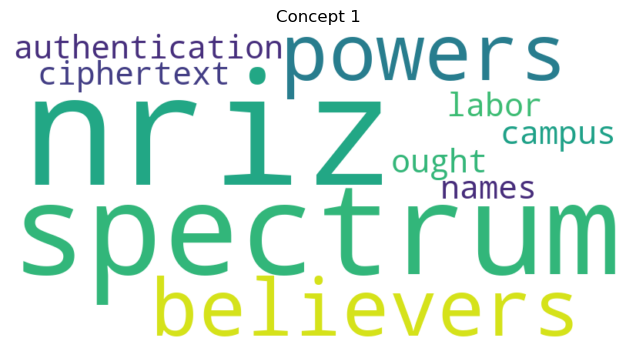

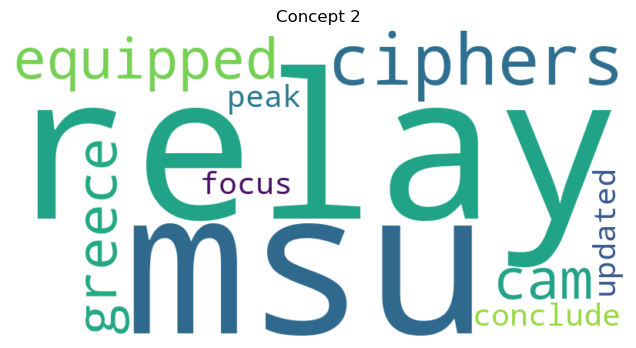

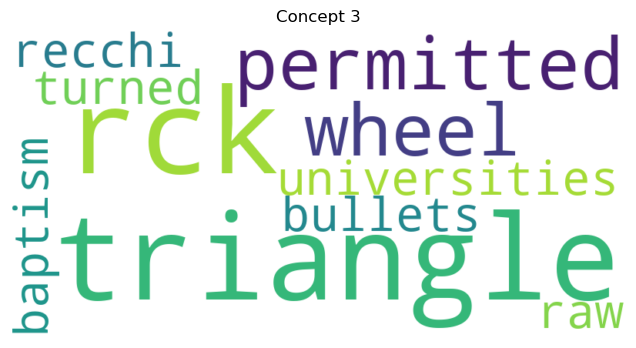

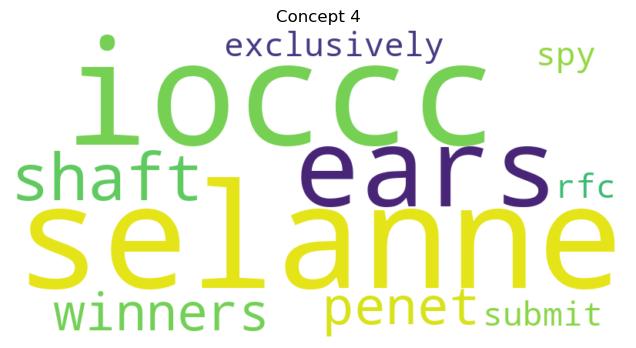

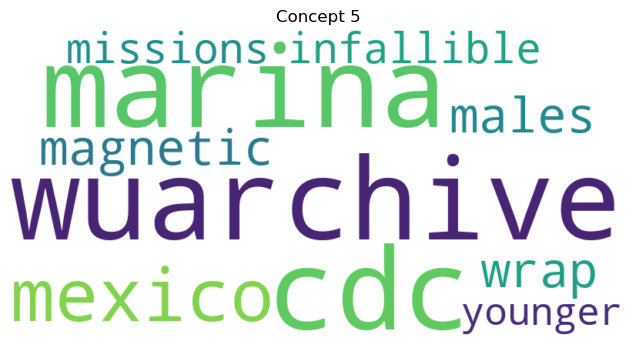

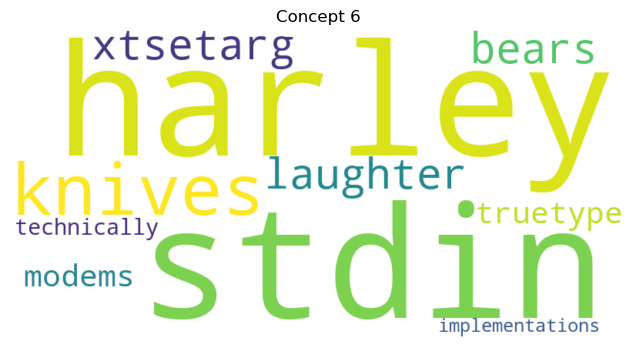

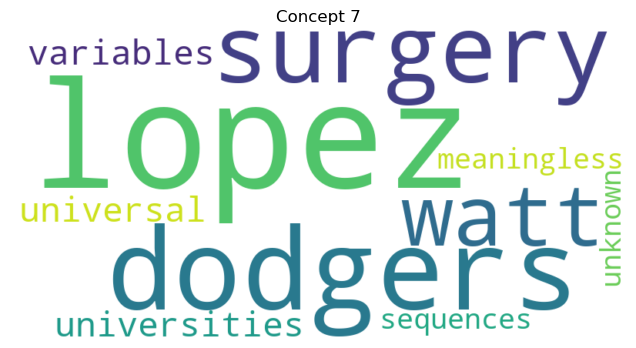

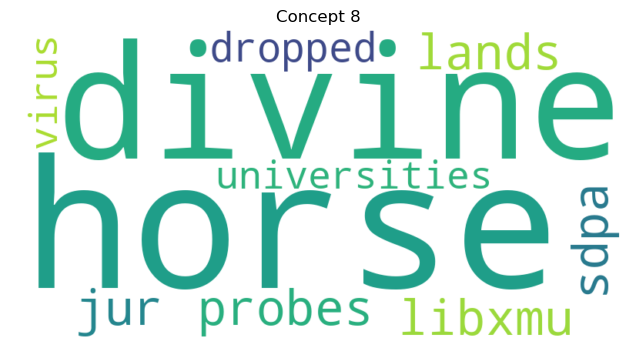

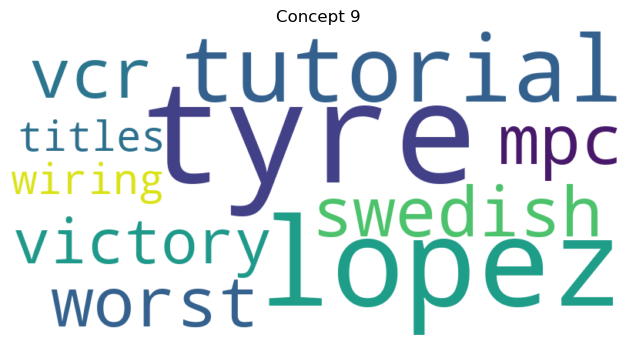

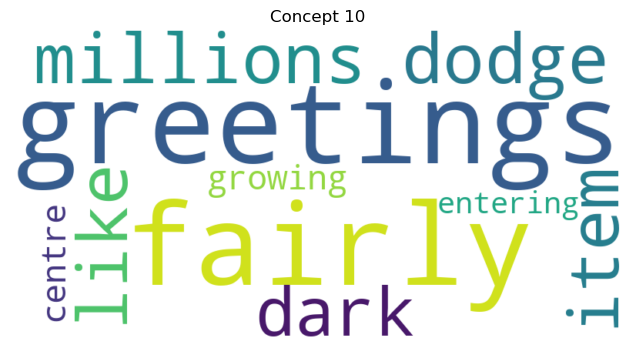

In [15]:
# ✅ 產生概念視覺化
gdcm.visualize()

In [16]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

def compute_coherence(concept_words_list, texts, method="c_v"):
    """
    計算概念內的詞彙 Coherence。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念內的關鍵詞（`get_concept_words()` 提供）
    - texts: List[List[str]]，原始文本分詞（用於計算 Coherence）
    - method: "c_v", "c_uci", "c_npmi"（選擇不同 Coherence 方法）

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_scores = []
    for concept_words in concept_words_list:
        cm = CoherenceModel(topics=[concept_words], texts=texts, dictionary=dictionary, coherence=method)
        coherence_scores.append(cm.get_coherence())
    
    return coherence_scores

In [17]:
concept_words_list = gdcm.get_concept_words(top_k=10, concept_dist="cosine")  # 取得概念內的詞
texts = [text.split() for text in newsgroups_train.data]  # 轉換文本為 token
coherence_scores = compute_coherence(concept_words_list, texts, method="c_npmi")

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Coherence: {score:.4f}")

Concept 1 Coherence: -0.3540
Concept 2 Coherence: -0.4043
Concept 3 Coherence: -0.3576
Concept 4 Coherence: -0.3210
Concept 5 Coherence: -0.3865
Concept 6 Coherence: -0.2699
Concept 7 Coherence: -0.3729
Concept 8 Coherence: -0.3519
Concept 9 Coherence: -0.3391
Concept 10 Coherence: -0.2735


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_coherence(concept_words_list, word_vectors):
    """
    計算每個概念內詞向量的平均餘弦相似度，評估內聚性。

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - word_vectors: dict，詞向量字典，例如 Word2Vec/GloVe/BERT 的 embeddings

    Returns:
    - coherence_scores: List[float]，每個概念的平均相似度
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        vectors = [word_vectors[word] for word in concept_words if word in word_vectors]
        
        if len(vectors) < 2:
            coherence_scores.append(0)  # 如果概念內少於 2 個詞，設為 0
            continue
        
        similarity_matrix = cosine_similarity(vectors)
        avg_similarity = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].mean()
        coherence_scores.append(avg_similarity)
    
    return coherence_scores

In [19]:
# 獲取詞向量
word_vectors = {word: gdcm.embedding_i.weight.data.cpu().numpy()[idx] for idx, word in enumerate(vocab)}

# 計算 Coherence
cosine_coherence_scores = compute_cosine_coherence(concept_words_list, word_vectors)

for i, score in enumerate(cosine_coherence_scores):
    print(f"Concept {i+1} Cosine Coherence: {score:.4f}")

Concept 1 Cosine Coherence: 0.2773
Concept 2 Cosine Coherence: 0.2588
Concept 3 Cosine Coherence: 0.3290
Concept 4 Cosine Coherence: 0.2021
Concept 5 Cosine Coherence: 0.2253
Concept 6 Cosine Coherence: 0.2979
Concept 7 Cosine Coherence: 0.2381
Concept 8 Cosine Coherence: 0.2248
Concept 9 Cosine Coherence: 0.2272
Concept 10 Cosine Coherence: 0.1937


In [20]:
from itertools import combinations

def compute_jaccard_coherence(concept_words_list, texts):
    """
    計算 Jaccard Similarity 作為 Coherence 分數。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞
    
    Returns:
    - coherence_scores: List[float]，每個概念的 Jaccard 相似度平均值
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        pairs = list(combinations(concept_words, 2))  # 生成所有單詞對
        
        jaccard_scores = []
        for w1, w2 in pairs:
            docs_w1 = {i for i, doc in enumerate(texts) if w1 in doc}
            docs_w2 = {i for i, doc in enumerate(texts) if w2 in doc}
            
            intersection = len(docs_w1 & docs_w2)
            union = len(docs_w1 | docs_w2)
            
            if union == 0:
                jaccard_scores.append(0)
            else:
                jaccard_scores.append(intersection / union)
        
        coherence_scores.append(np.mean(jaccard_scores) if jaccard_scores else 0)
    
    return coherence_scores

In [21]:
jaccard_coherence_scores = compute_jaccard_coherence(concept_words_list, texts)

for i, score in enumerate(jaccard_coherence_scores):
    print(f"Concept {i+1} Jaccard Coherence: {score:.4f}")

Concept 1 Jaccard Coherence: 0.0110
Concept 2 Jaccard Coherence: 0.0087
Concept 3 Jaccard Coherence: 0.0084
Concept 4 Jaccard Coherence: 0.0103
Concept 5 Jaccard Coherence: 0.0074
Concept 6 Jaccard Coherence: 0.0052
Concept 7 Jaccard Coherence: 0.0100
Concept 8 Jaccard Coherence: 0.0096
Concept 9 Jaccard Coherence: 0.0103
Concept 10 Jaccard Coherence: 0.0131


In [22]:
from collections import defaultdict
import numpy as np

def compute_mimno_coherence(concept_words_list, texts):
    """
    Mimno 和 McCallum (2008) Coherence 計算方式，避免 division by zero 錯誤

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞後的列表

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    # 記錄每個詞在哪些文件中出現
    doc_word_counts = defaultdict(set)  # 用 set 存儲詞的文件索引
    for i, text in enumerate(texts):
        for word in set(text):  # 轉換為 set，避免重複計數
            doc_word_counts[word].add(i)

    coherence_scores = []
    for concept_words in concept_words_list:
        pairs = [(w1, w2) for i, w1 in enumerate(concept_words) for w2 in concept_words[i+1:]]
        coherence = []
        for w1, w2 in pairs:
            D_w1 = len(doc_word_counts[w1])  # 包含 w1 的文件數量
            D_w1_w2 = len(doc_word_counts[w1] & doc_word_counts[w2])  # 同時包含 w1 和 w2 的文件數量
            
            # **防止 division by zero**
            if D_w1 == 0:
                continue  # 如果 w1 不在任何文檔中，跳過這個詞對
            
            score = np.log((D_w1_w2 + 1) / (D_w1 + 1e-10))  # 加一個小的數值避免除零錯誤
            coherence.append(score)

        coherence_scores.append(np.mean(coherence) if coherence else -np.inf)  # 避免空列表報錯

    return coherence_scores

In [23]:
mimno_coherence_scores = compute_mimno_coherence(concept_words_list, texts)

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Mimno Coherence: {score:.4f}")

Concept 1 Mimno Coherence: -0.3540
Concept 2 Mimno Coherence: -0.4043
Concept 3 Mimno Coherence: -0.3576
Concept 4 Mimno Coherence: -0.3210
Concept 5 Mimno Coherence: -0.3865
Concept 6 Mimno Coherence: -0.2699
Concept 7 Mimno Coherence: -0.3729
Concept 8 Mimno Coherence: -0.3519
Concept 9 Mimno Coherence: -0.3391
Concept 10 Mimno Coherence: -0.2735
